In [1]:
import os
import h5py
import json
import keras
import random 
import imageio
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import tree
from keras import backend as K
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

Using TensorFlow backend.


In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.drop("Unnamed: 0", inplace=True, axis=1)
Data.drop("Unnamed: 0.1", inplace=True, axis=1)

In [5]:
Data.dtypes

Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title                                      object
Project Essay                                      object
Project Short 

In [6]:
# from pandas import DataFrame
# import seaborn as sn
# t=Data.columns
# t=t[::-1]
# df = DataFrame(Data[t],columns=t)

# fig, ax = plt.subplots(figsize=(15,10),sharex=True, sharey=True) 
# corrMatrix = df.corr()
# sn.heatmap(corrMatrix, annot=True,annot_kws={"size": 10},ax=ax)

count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


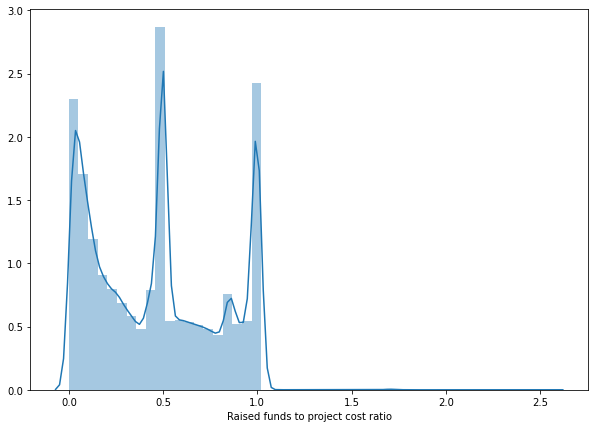

In [7]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date","Project Short Description_polarity",
        "Project Short Description_subjectivity","Project Essay_polarity","Project Essay_subjectivity",
         "Project Need Statement_polarity","Project Need Statement_subjectivity"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


In [8]:
Grouped_data_Final[y]

Project ID
000009891526c0ade7180f8423792063    0.207673
00000ce845c00cbf0686c992fc369df4    0.683031
00002d44003ed46b066607c5455a999a    0.399810
00002eb25d60a09c318efbd0797bffb5    0.107870
0000300773fe015f870914b42528541b    1.000000
                                      ...   
ffff8bee61b72c484b10e43aa9e35bc9    0.524360
ffff98098650c5e07fa7f40030fbe9e2    0.332200
ffff9bb21699f79266cc7cbc208890a0    0.256458
ffffd8f0fbfa10b99efe90a5ee13c5df    0.500000
fffffcc42d1bf7ab742a4fa2d820f9f0    0.481306
Name: Raised funds to project cost ratio, Length: 743945, dtype: float64

count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


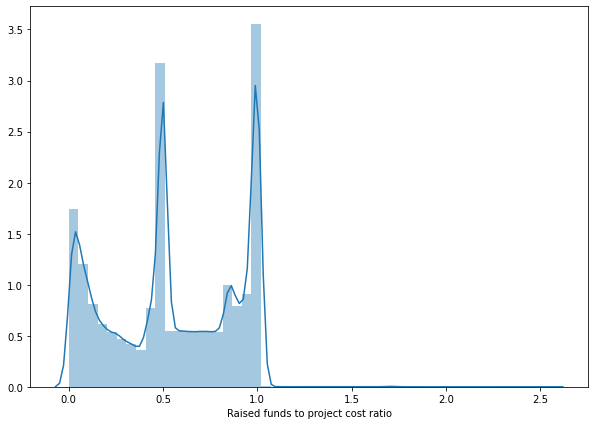

In [9]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date","Project Short Description_polarity",
        "Project Short Description_subjectivity","Project Essay_polarity","Project Essay_subjectivity",
         "Project Need Statement_polarity","Project Need Statement_subjectivity"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [10]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
    Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
    Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()

    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    #=================================== Initiate Time Variables ====================================
    
    print("Initiate Time Variables")
    MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
    MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
    Time_period = timedelta(days=Time_period_indays)  
    T_current = MinT- Time_period +timedelta(days=120) 
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')
    
    
    #=================================== Loop over time frams =======================================
    
    print("Time iteration is starting\n")
    while (T_current<MaxT-Time_period):
        
        T_current = T_current+ Time_period
        Time_points+=[T_current]
        T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
        T_Train_end = T_current-Time_period  #End of the data frame
        print("As of Date:",T_current,"\n"+"="*85)
        
    #====================================== Extract the frams ======================================= 
    
        # Extracts projects posted before the Current(As of) date
        Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  
        
        # Extracts projects posted after the start date of the Time window
        Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]
        
        #Time period to be consided for the donations since posted (30days, as default)
        Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]
        
        #Express the donation amount as a ratio of to the Project cost
        Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]
        
        
    #=========================== Do One-Hot_Encoding for Categorical Variables ======================
    
        for var in Model_variables_cat:
            Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
            Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
            Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
            Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
            #copy the columns to the main data set 
            for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]
                
        #Add the columns which have not been one-hot-encoded
        for i in Model_variables:
            if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0
    
    
    #============================================ Imputing ==========================================
        Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)
                
    
    #=================================== Training set Creation =====================================
    
        #extract the training set from the timewindow
        Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]
        
        #Group by Project ID
        Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
        Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
        Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
        Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]
        
        # Define Fund_Ratio_Treshold
        Fund_Ratio_Treshold = Fund_Ratio_treshold
        Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()
        
        # Genarate the Label for the dataset 
        Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                           Fund_Ratio_Treshold  else 0, axis=1)
        
        X_train = Train_Data_Final.loc[:,Model_variables]
        Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]
        
        
    #==================================== Testing set Creation =====================================
    
        #extract the training set from the timewindow
        Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]
        
        #Group by Project ID
        Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
        Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
        Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
        Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]
        
        # Genarate the Label for the dataset 
        Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                         Fund_Ratio_Treshold  else 0, axis=1)
        X_test = Test_Data_Final.loc[:,Model_variables]
        Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]
        
        
    #===================================== Model Training =========================================
    
        Classifier.fit(X_train, Y_train)
        
        # Predict on training 
        Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
        Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
        # Predict on testing 
        Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
        Test_Data_Final["Y_pred"] = Classifier.predict(X_test)

        
    #====================================== Evaluation Trainign  ============================================
    
        Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
        Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()
        
        Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
        Training_Precision=Training_TP/(Training_TP+Training_FP)
        Training_Recall=Training_TP/(Training_TP+Training_FN)
        
        print(Classifier.__class__.__name__,' Trainign Accuracy = ',Training_Accuracy)
        print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
              "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)
        
        
    #====================================== Evaluation Testign  ============================================   
    
        Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
        Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()
        
        Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
        Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
        Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)
        
        print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
        print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
              "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)
        
    #====================================== Evaluation Top K  ============================================        
        
        Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
        Top_K=Test_Data_Final.head(K)
        Y_test_Top_K =  Top_K.loc[:,["Label"]] 
        Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
        Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
        if len(Testing_Top_K_CM.ravel())==4:
            Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
        else:
            Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K
        
        Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                    + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
        Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
        Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)
        
        print(Classifier.__class__.__name__,' Top K Testing Accuracy = ',Testing_Top_K_Accuracy)
        print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
              "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)
        
     #====================================== save computed values  ============================================       
        Output["Overall_Training_Accuracy"] += [Training_Accuracy]
        Output["Overall_Training_Precision"] += [Training_Precision]
        Output["Overall_Training_Recall"] += [Training_Recall ]
        
        Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
        Output["Overall_Testing_Precision"] += [Testing_Precision]
        Output["Overall_Testing_Recall"] += [Testing_Recall]
        
        Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
        Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
        Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
    
    
    Output["Classifier"]=Classifier
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    return Output,Test_Data_Final,Train_Data_Final
        

In [11]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(learning_rate=0.3, n_estimators=500, random_state=43)

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity","Teacher Project Posted Sequence"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category","Project Type",
                      "School State"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.03)

Initiatnig the Columns
Variables considered in model training
> Number of dates since posted True
> Project ID True
> Donation Amount True
> Project Cost True
> Project Posted Date True
> Project Expiration Date True
> Donation Received Date True
> Project Short Description_polarity True
> Project Short Description_subjectivity True
> Project Essay_polarity True
> Project Essay_subjectivity True
> Project Need Statement_polarity True
> Project Need Statement_subjectivity True

One-Hot-Encoding removing columns identification
Initiate Time Variables
Time iteration is starting

As of Date: 2013-05-01 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6687002311841768
	Training_TP: 5282 	Training_FP: 2655 
	Training_TN: 5131 	Training_FN: 2504

AdaBoostClassifier  Testing Accuracy =  0.6417112299465241
	Testing_TP: 1248 	Testing_FP: 810 
	Testing_TN: 1392 	Testing_FN: 664

AdaBoostClassifier  Top K Testing Accuracy =  0.77
	Testing_Top_K_TP: 77 	Testing_Top_K_FP: 23 
	Testing_Top_K_TN: 

AdaBoostClassifier  Trainign Accuracy =  0.6597488433575678
	Training_TP: 5013 	Training_FP: 2596 
	Training_TN: 4969 	Training_FN: 2552

AdaBoostClassifier  Testing Accuracy =  0.6325800376647834
	Testing_TP: 1819 	Testing_FP: 982 
	Testing_TN: 1540 	Testing_FN: 969

AdaBoostClassifier  Top K Testing Accuracy =  0.82
	Testing_Top_K_TP: 82 	Testing_Top_K_FP: 18 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-08-24 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6494974874371859
	Training_TP: 4950 	Training_FP: 2689 
	Training_TN: 4873 	Training_FN: 2612

AdaBoostClassifier  Testing Accuracy =  0.5971068660022149
	Testing_TP: 3771 	Testing_FP: 2832 
	Testing_TN: 4856 	Testing_FN: 2989

AdaBoostClassifier  Top K Testing Accuracy =  0.67
	Testing_Top_K_TP: 67 	Testing_Top_K_FP: 33 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2014-09-23 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.644701030927835
	Training_TP: 7838 	Training_FP: 4329 
	Training_TN: 7796

AdaBoostClassifier  Trainign Accuracy =  0.6624156039009752
	Training_TP: 15070 	Training_FP: 7709 
	Training_TN: 14952 	Training_FN: 7591

AdaBoostClassifier  Testing Accuracy =  0.6538202138934387
	Testing_TP: 3392 	Testing_FP: 1867 
	Testing_TN: 3394 	Testing_FN: 1726

AdaBoostClassifier  Top K Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2015-12-17 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6662886948633632
	Training_TP: 14735 	Training_FP: 7403 
	Training_TN: 14645 	Training_FN: 7312

AdaBoostClassifier  Testing Accuracy =  0.6351988217967599
	Testing_TP: 4314 	Testing_FP: 2701 
	Testing_TN: 4312 	Testing_FN: 2253

AdaBoostClassifier  Top K Testing Accuracy =  0.91
	Testing_Top_K_TP: 91 	Testing_Top_K_FP: 9 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2016-01-16 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6589844071140829
	Training_TP: 12211 	Training_FP: 6410 
	Training_T

AdaBoostClassifier  Trainign Accuracy =  0.671877261542915
	Training_TP: 13975 	Training_FP: 6850 
	Training_TN: 13877 	Training_FN: 6752

AdaBoostClassifier  Testing Accuracy =  0.6597191095174062
	Testing_TP: 3864 	Testing_FP: 2556 
	Testing_TN: 4967 	Testing_FN: 1999

AdaBoostClassifier  Top K Testing Accuracy =  0.79
	Testing_Top_K_TP: 79 	Testing_Top_K_FP: 21 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-04-10 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6728909054646989
	Training_TP: 13475 	Training_FP: 6540 
	Training_TN: 13516 	Training_FN: 6581

AdaBoostClassifier  Testing Accuracy =  0.6446286701208981
	Testing_TP: 4351 	Testing_FP: 2244 
	Testing_TN: 4980 	Testing_FN: 2900

AdaBoostClassifier  Top K Testing Accuracy =  0.85
	Testing_Top_K_TP: 85 	Testing_Top_K_FP: 15 
	Testing_Top_K_TN: 0 	Testing_Top_K_FN: 0

As of Date: 2017-05-10 00:00:00 
AdaBoostClassifier  Trainign Accuracy =  0.6651379334306163
	Training_TP: 13853 	Training_FP: 6919 
	Training_T

In [12]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Classifier', 'Model_variables', 'Time_points'])

In [13]:
Output["Model_variables"]

['Project Cost',
 'Number of dates since posted',
 'School Percentage Free Lunch',
 'Project Short Description_polarity',
 'Project Short Description_subjectivity',
 'Project Essay_polarity',
 'Project Essay_subjectivity',
 'Project Need Statement_polarity',
 'Project Need Statement_subjectivity',
 'Teacher Project Posted Sequence',
 'School Metro Type_rural',
 'School Metro Type_town',
 'School Metro Type_unknown',
 'School Metro Type_urban',
 'Teacher Prefix_Dr.',
 'Teacher Prefix_Mrs.',
 'Teacher Prefix_Ms.',
 'Teacher Prefix_Mx.',
 'Teacher Prefix_Teacher',
 'Teacher Prefix_nan',
 'Project Grade Level Category_Grades 3-5',
 'Project Grade Level Category_Grades 9-12',
 'Project Grade Level Category_Grades PreK-2',
 'Project Grade Level Category_unknown',
 'Project Type_Professional Development',
 'Project Type_Student-Led',
 'School State_Alabama',
 'School State_Alaska',
 'School State_Arizona',
 'School State_Arkansas',
 'School State_California',
 'School State_Colorado',
 'Schoo

Text(0.5, 1.0, 'Precision-Recall curve')

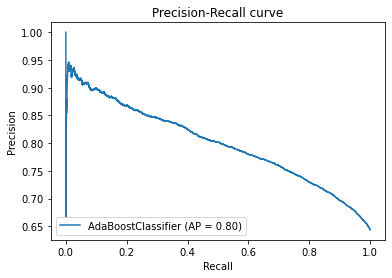

In [14]:
X_test = Test_Data_Final.loc[:,Output["Model_variables"]]
Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]

disp = plot_precision_recall_curve(Output["Classifier"], X_test, Y_test)
disp.ax_.set_title('Precision-Recall curve')

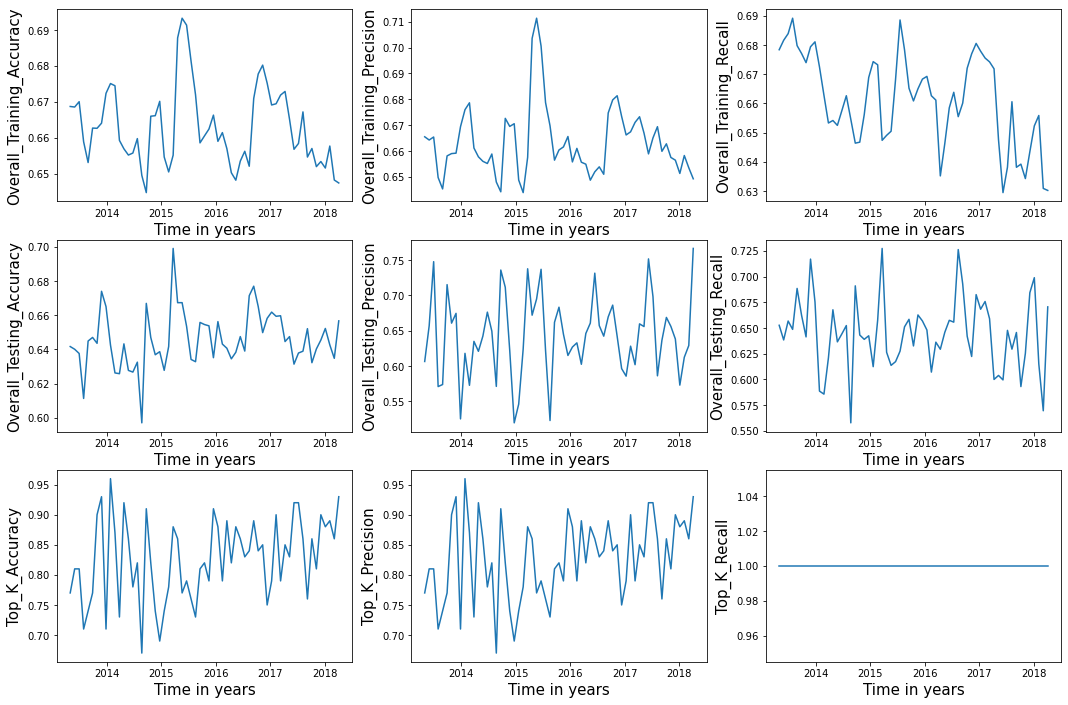

In [15]:
n_cols=3
n_rows=3
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0][0]
sns.lineplot(data=Output, x="Time_points", y="Overall_Training_Accuracy",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Training_Accuracy",fontsize=15);

ax = axs[0][1]
sns.lineplot(data=Output, x="Time_points", y="Overall_Training_Precision",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Training_Precision",fontsize=15);

ax = axs[0][2]
sns.lineplot(data=Output, x="Time_points", y="Overall_Training_Recall",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Training_Recall",fontsize=15);

ax = axs[1][0]
sns.lineplot(data=Output, x="Time_points", y="Overall_Testing_Accuracy",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Testing_Accuracy",fontsize=15);

ax = axs[1][1]
sns.lineplot(data=Output, x="Time_points", y="Overall_Testing_Precision",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Testing_Precision",fontsize=15);

ax = axs[1][2]
sns.lineplot(data=Output, x="Time_points", y="Overall_Testing_Recall",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Overall_Testing_Recall",fontsize=15);

ax = axs[2][0]
sns.lineplot(data=Output, x="Time_points", y="Top_K_Accuracy",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K_Accuracy",fontsize=15);

ax = axs[2][1]
sns.lineplot(data=Output, x="Time_points", y="Top_K_Precision",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K_Precision",fontsize=15);

ax = axs[2][2]
sns.lineplot(data=Output, x="Time_points", y="Top_K_Recall",ax=ax)
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K_Recall",fontsize=15);

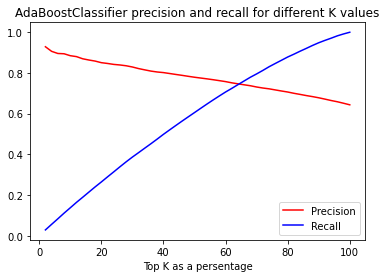

In [16]:
prT=[]
reT=[]
t=[]
k=2
Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
Test_Data_Final['Y_pred']=0
while (k<=100):
    Test_Data_Final.loc[Test_Data_Final.head(int(len(Test_Data_Final)*k/100)).index,'Y_pred'] = 1
    
    Y_test_k =  Test_Data_Final.loc[:,["Label"]] 
    Y_pred_k =  Test_Data_Final.loc[:,["Y_pred"]] 

    cm= confusion_matrix(Y_test_k,Y_pred_k)
    if len(cm.ravel())==4:TN, FP ,FN, TP =  cm.ravel()
    else: TN, FP ,FN, TP=0,0,0,100
    t+=[k]
#     print(len(Y_test_k[Y_test_k["Label"]==1])/len(Tk))
    preci=TP/(TP+FP)
    prT+=[preci]
    rec=TP/(TP+FN)
    reT+=[rec]
    k+=2
ax1=plt.plot(t,prT, 'r',label='Precision')
ax2=plt.plot(t,reT, 'b',label='Recall')
plt.xlabel("Top K as a persentage")

plt.title(Output["Classifier"].__class__.__name__+" precision and recall for different K values")
plt.legend()
plt.show()

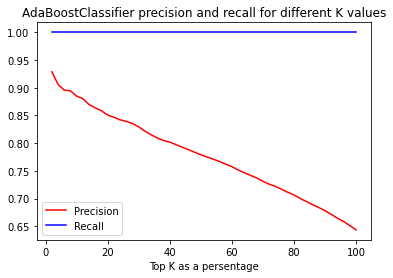

In [17]:
prT=[]
reT=[]
t=[]
k=2
Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
while (k<=100):
    Tk=Test_Data_Final.head(int(len(Test_Data_Final)*k/100))
    Y_test_k =  Tk.loc[:,["Label"]] 
    Y_pred_k =  Tk.loc[:,["Y_pred"]] 
    cm= confusion_matrix(Y_test_k,Y_pred_k)
    if len(cm.ravel())==4:TN, FP ,FN, TP =  cm.ravel()
    else: TN, FP ,FN, TP=0,0,0,100
    t+=[k]
#     print(len(Y_test_k[Y_test_k["Label"]==1])/len(Tk))
    preci=TP/(TP+FP)
    prT+=[preci]
    rec=TP/(TP+FN)
    reT+=[rec]
    k+=2
ax1=plt.plot(t,prT, 'r',label='Precision')
ax2=plt.plot(t,reT, 'b',label='Recall')
plt.xlabel("Top K as a persentage")

plt.title(Output["Classifier"].__class__.__name__+" precision and recall for different K values")
plt.legend()
plt.show()

In [18]:
import lime
import lime.lime_tabular

X_train = Train_Data_Final.loc[:,Output["Model_variables"]]

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=Output["Model_variables"], 
                    class_names=['Label'], 
                    # categorical_features=, n
                    # There is no categorical features in this example, otherwise specify them.                               
                    verbose=True, mode='regression')

explainer

Intercept 0.5027615100504904
Prediction_local [0.54022879]
Right: 0


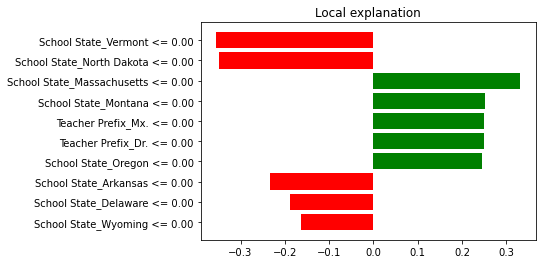

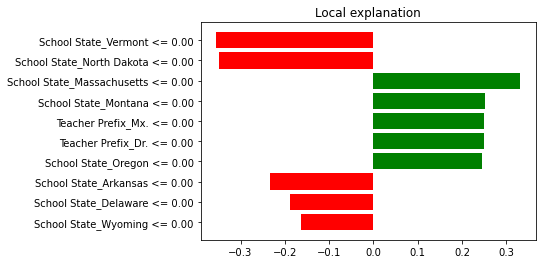

In [19]:
exp = explainer.explain_instance(X_test.iloc[-1], Output["Classifier"].predict)
exp.as_pyplot_figure()

In [20]:
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.30692050216365746
Prediction_local [1.22750431]
Right: 1


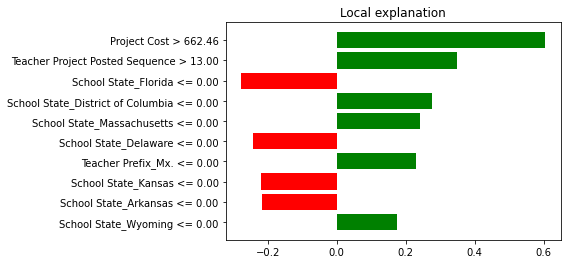

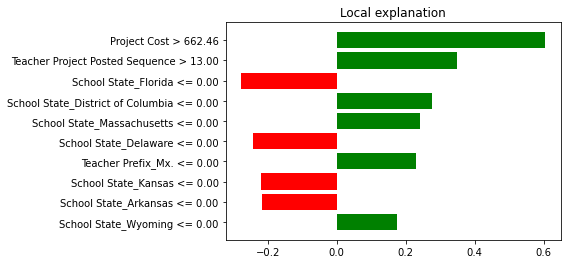

In [21]:
exp = explainer.explain_instance(X_test.iloc[0], Output["Classifier"].predict)
exp.as_pyplot_figure()

In [22]:
exp.show_in_notebook(show_table=True, show_all=False)

In [23]:
import shap
explainer = shap.TreeExplainer(Output["Classifier"])
X_train = Train_Data_Final.loc[:,Output["Model_variables"]]
shap_values = explainer.shap_values(X_train)

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[0][0], X_test.iloc[0])